# Importing the main libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import PowerTransformer

from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
import itertools


### Loading Dataset

In [2]:
train_url = '/kaggle/input/playground-series-s3e9/train.csv'
train_df = pd.read_csv(train_url,index_col = 'id')

test_url = '/kaggle/input/playground-series-s3e9/test.csv'
test_df = pd.read_csv(test_url,index_col = 'id')

# Original data didn't seem to improve model predictions so i will not include them in training

# original_url = '/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv'
# original_df = pd.read_csv(original_url)
# original_df.rename(columns = {'CementComponent ':'CementComponent'}, inplace = True)


In [3]:
#dropping the duplicated rows in data
# sets={'train':train_df,'test':test_df,'original':original_df}

# def dropping_duplicates(data):
#     data.drop_duplicates(inplace = True)
    
# drop_duplcated_list={'train':train_df,'original':original_df}   
# for n in drop_duplcated_list:
#     print(f"number of duplicated rows in {n} is {sets[n].duplicated().sum()}, they were dropped ")
#     dropping_duplicates(sets[n])
#     drop_duplcated_list[n].reset_index(drop=True,inplace=True)

In [4]:
#concatinating the train and original data 
# train_df = pd.concat([train_df,original_df],ignore_index=True)

In [5]:
#dropping the duplicated in the concatenated data
# print(f"A number of duplicated rows in concatenated train is {train_df.duplicated().sum()}, they were dropped")
# dropping_duplicates(train_df)
# train_df.reset_index(drop=True,inplace=True)

In [6]:
#showing the first 5 entries of the data
train_df.head()


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


### Description of Fields are as follows:-

- CementComponent:- Amount of cement is mixed  
- BlastFurnaceSlag:- Amount of Blast Furnace Slag is mixed  
- FlyAshComponent:- Amount of FlyAsh is mixed  
- WaterComponent:- Amount of water is mixed  
- SuperplasticizerComponent:- Amount of Super plasticizer is mixed  
- CoarseAggregateComponent:- Amount of Coarse Aggregate is mixed  
- FineAggregateComponent:- Amount of Coarse Aggregate is mixed  
- AgeInDays:- How many days it was left dry  
- Strength:- What was the final strength of concrete- (Target)  

# Descriptive Statistics

In [7]:
# Showing some infor of the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5407 entries, 0 to 5406
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            5407 non-null   float64
 1   BlastFurnaceSlag           5407 non-null   float64
 2   FlyAshComponent            5407 non-null   float64
 3   WaterComponent             5407 non-null   float64
 4   SuperplasticizerComponent  5407 non-null   float64
 5   CoarseAggregateComponent   5407 non-null   float64
 6   FineAggregateComponent     5407 non-null   float64
 7   AgeInDays                  5407 non-null   int64  
 8   Strength                   5407 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 422.4 KB


> ` All the data are numerical (float & int), there is no categorical columns `

In [8]:
# Showing some descriptive statistics of the data 
train_df.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


> ` some of the columns (lastFurnaceSlag, FlyAshComponent, WaterComponent, SuperplasticizerComponent, AgeInDays) seems skewed, we will further explore them using Data Visualization `

In [9]:
#Checking of number of unique values in each column
train_df.nunique()

CementComponent              314
BlastFurnaceSlag             224
FlyAshComponent              177
WaterComponent               215
SuperplasticizerComponent    112
CoarseAggregateComponent     342
FineAggregateComponent       376
AgeInDays                     15
Strength                     843
dtype: int64

> ` Although the data is numerical and continous, many values keeps repeating over the 5407 entries ` 

In [10]:
#Checking for nulls
train_df.isna().sum()

CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

> ` There is no nulls in our data `

In [11]:
# Splitting the target value from the data 

X_train = train_df.drop('Strength',axis=1)
y_train = train_df['Strength']

X_test = test_df

# Data Visualizations

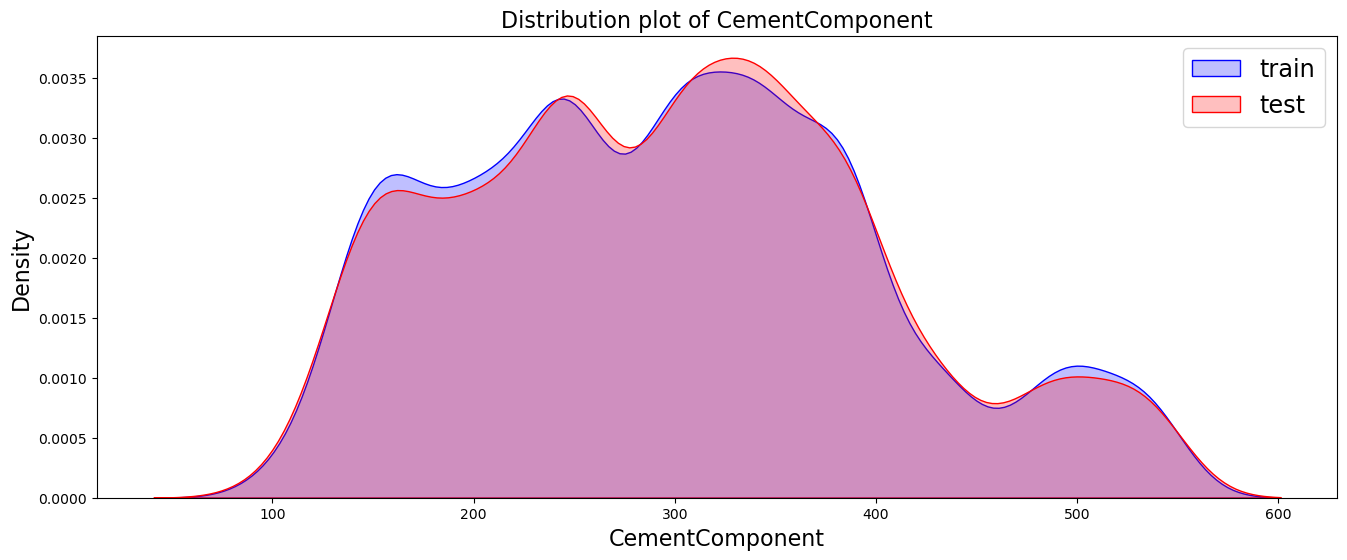

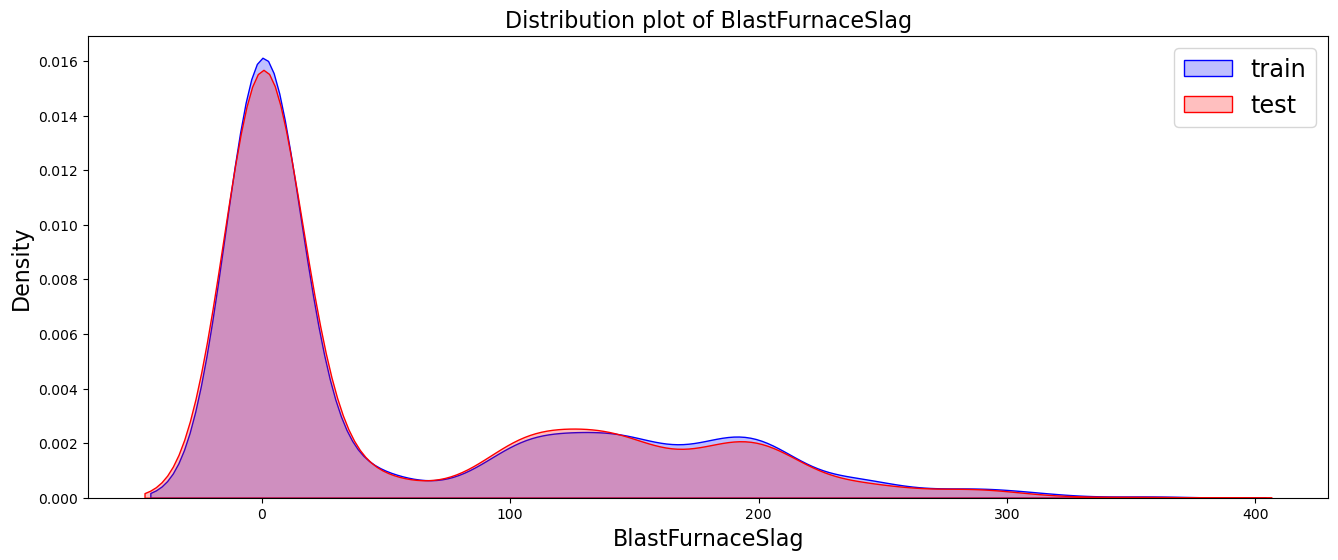

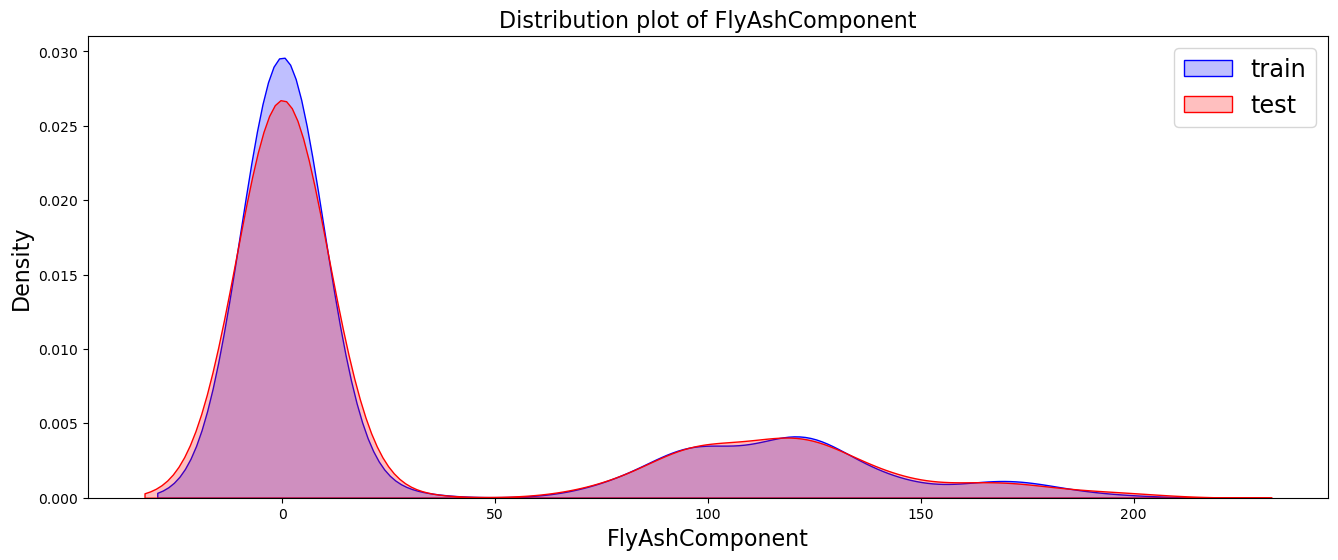

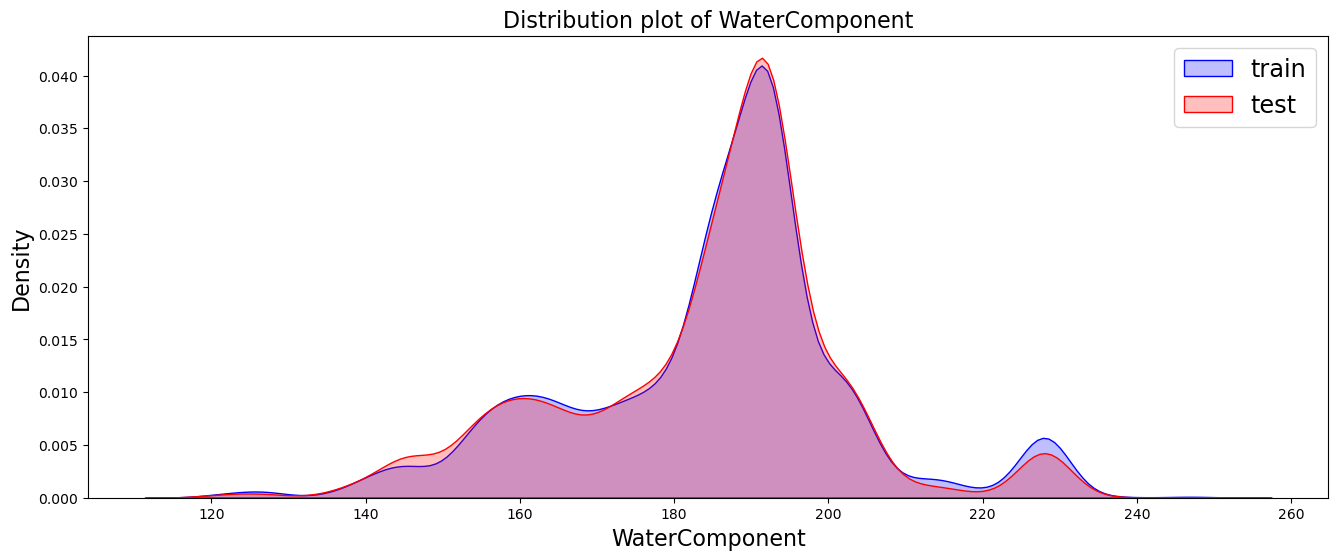

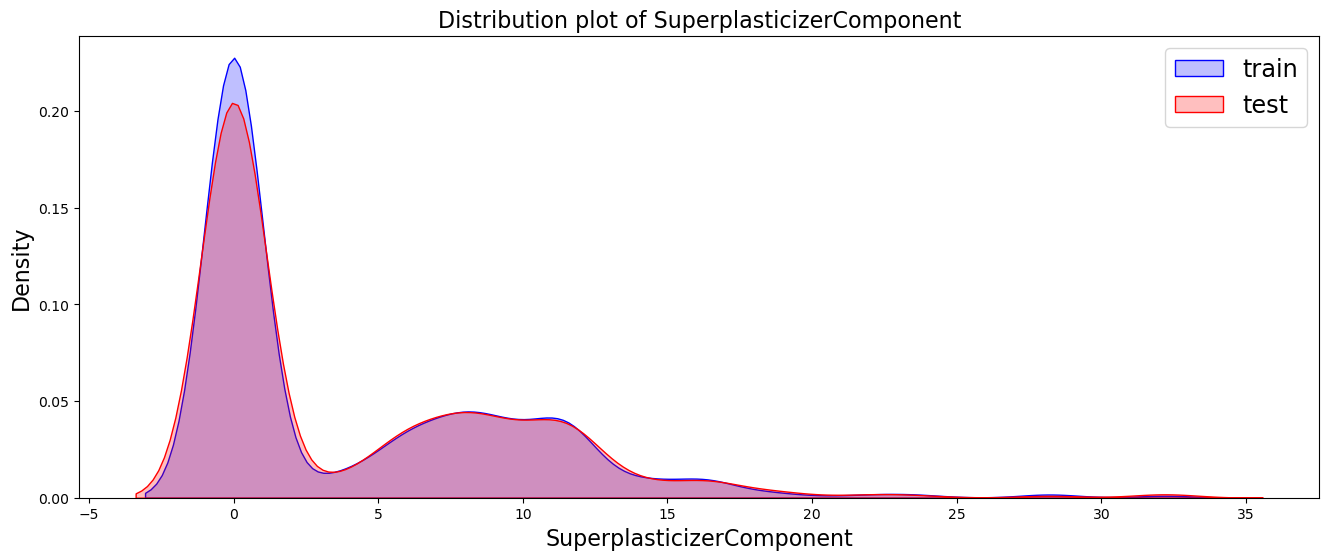

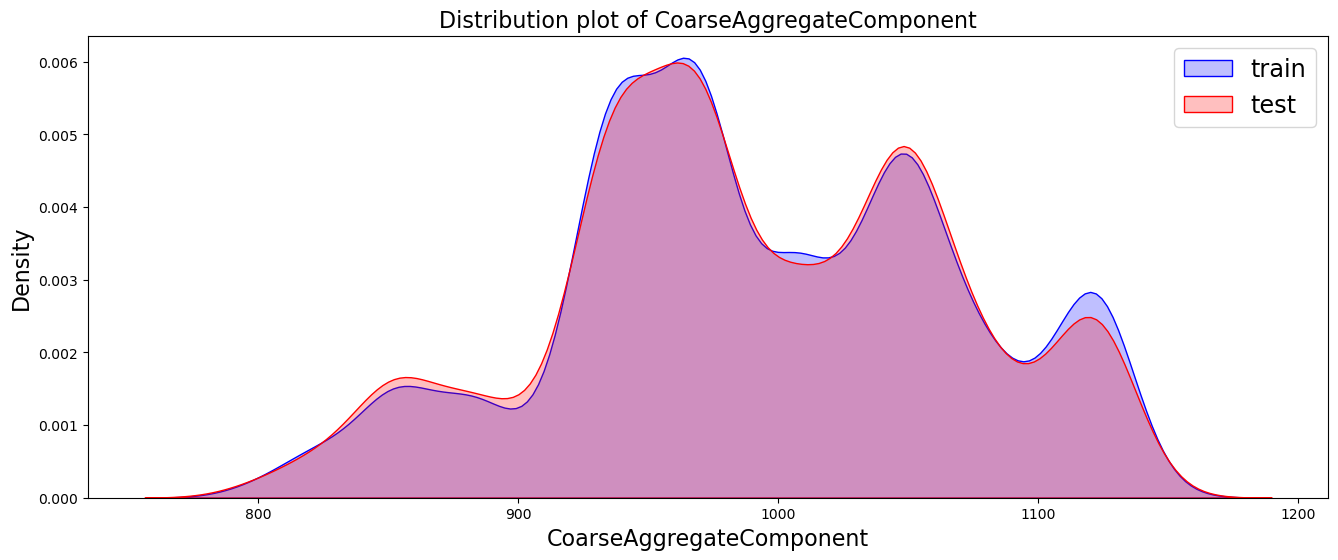

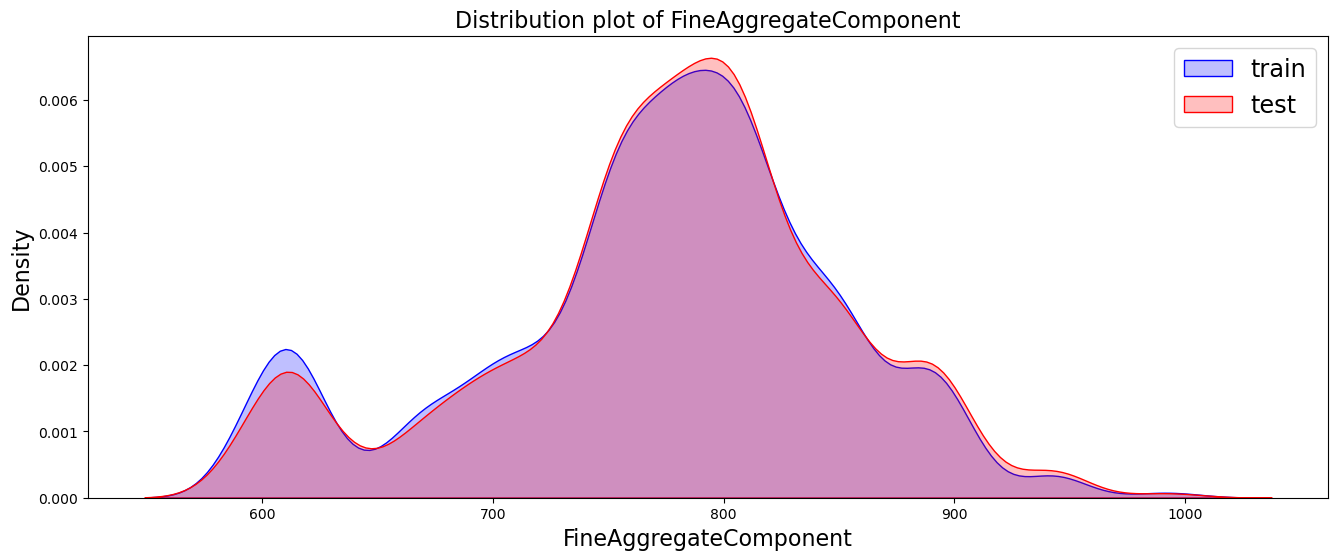

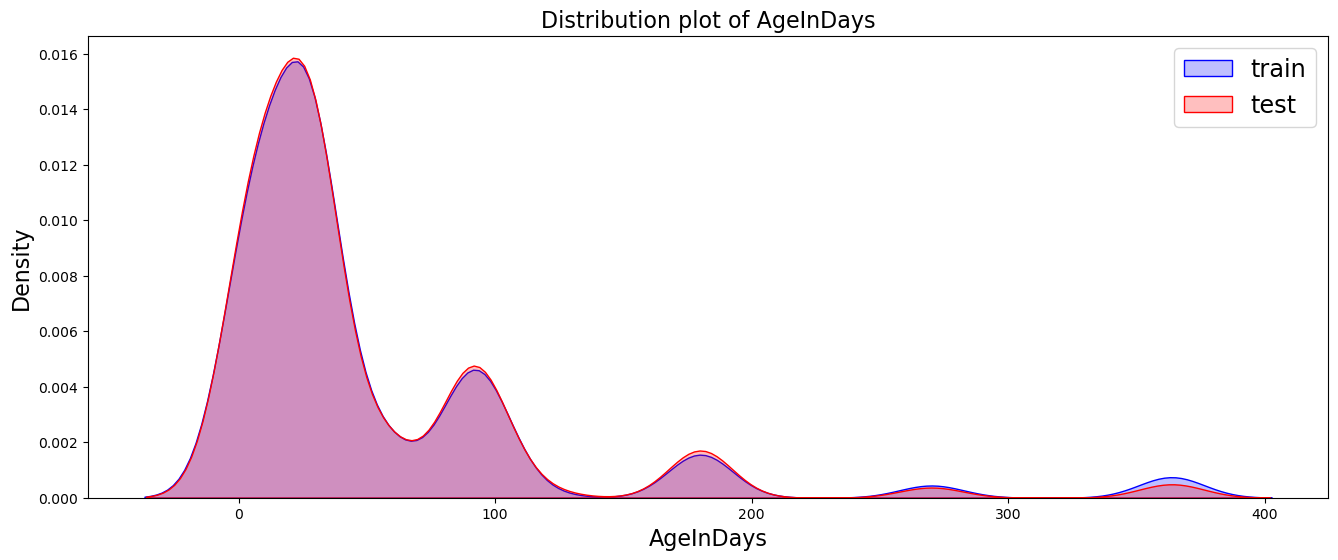

In [12]:
#Showing The distripution of each column in train and test data 
for column in X_train.columns:
    
    plt.figure(figsize=(16,6))
    sns.kdeplot(data=X_train, x=column, fill=True, color="blue", label='train')
    sns.kdeplot(data=X_test, x=column, fill=True, color="red", label='test')
    plt.legend(fontsize='xx-large')
    plt.title('Distribution plot of '+column,size=16)
    plt.xlabel(column,size=16)
    plt.ylabel('Density',size=16)
    plt.show()

> ` Some of the coulmns are skewed as i mentioned above, we will try to fix them later. Also Some of the columns contain very large number of zeroes.`


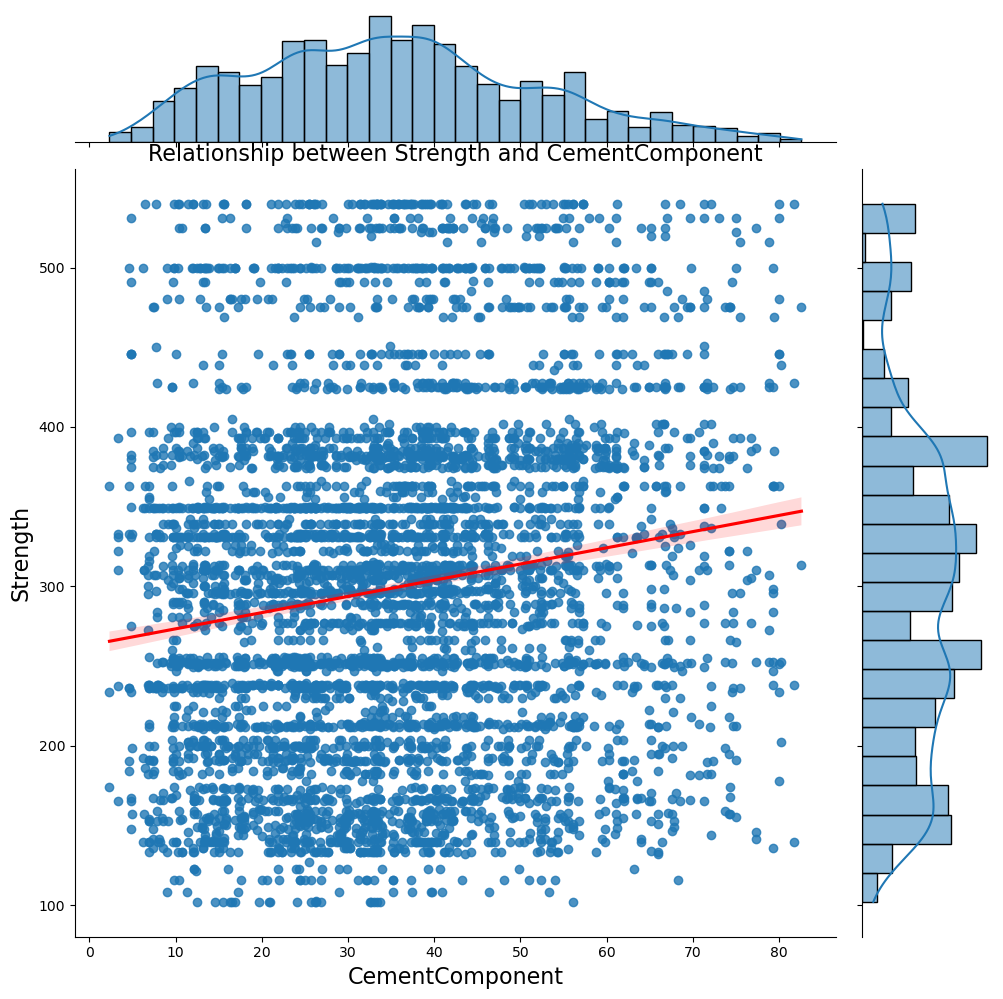

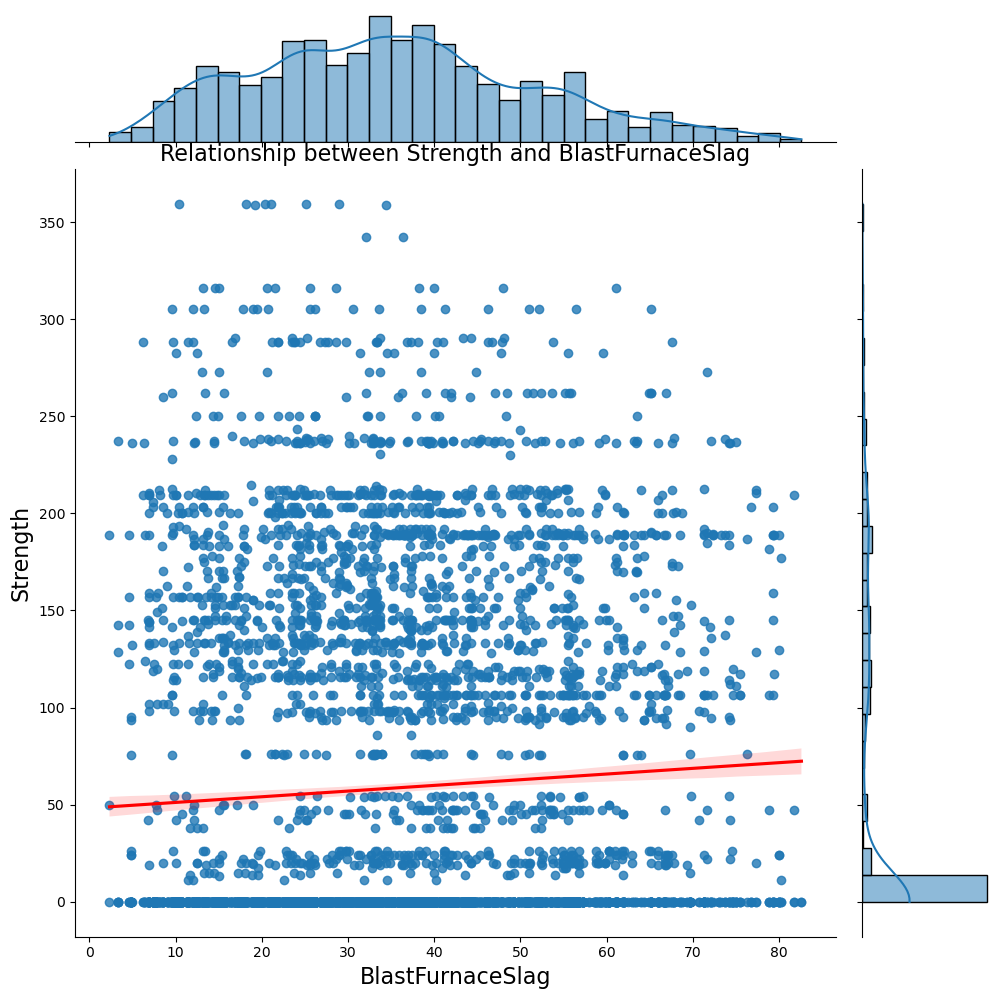

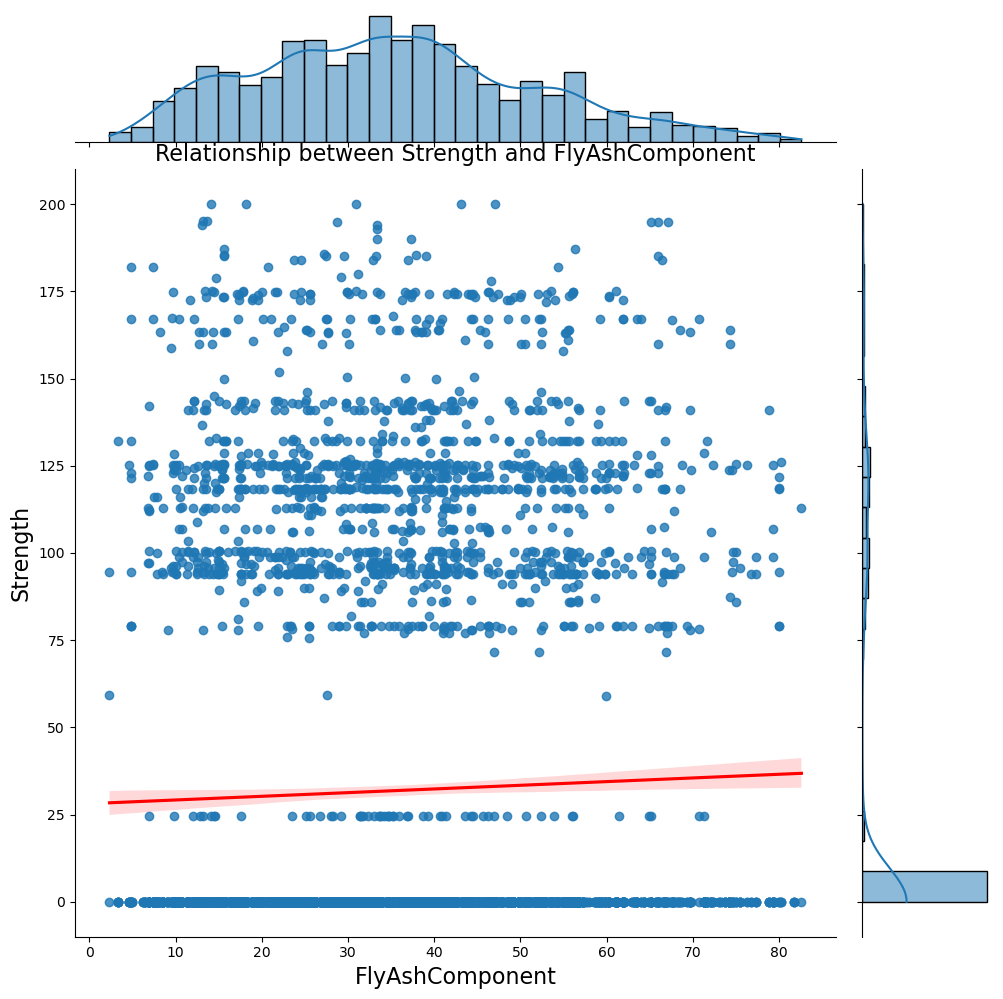

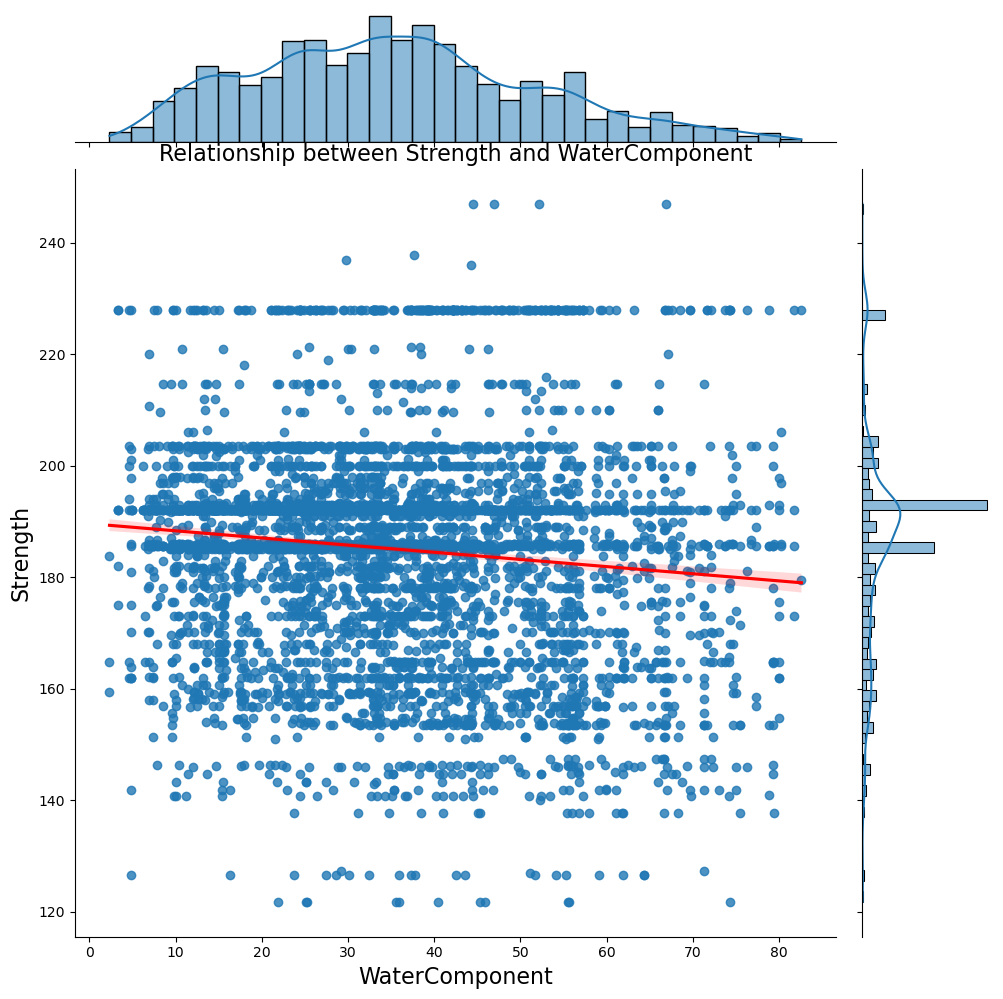

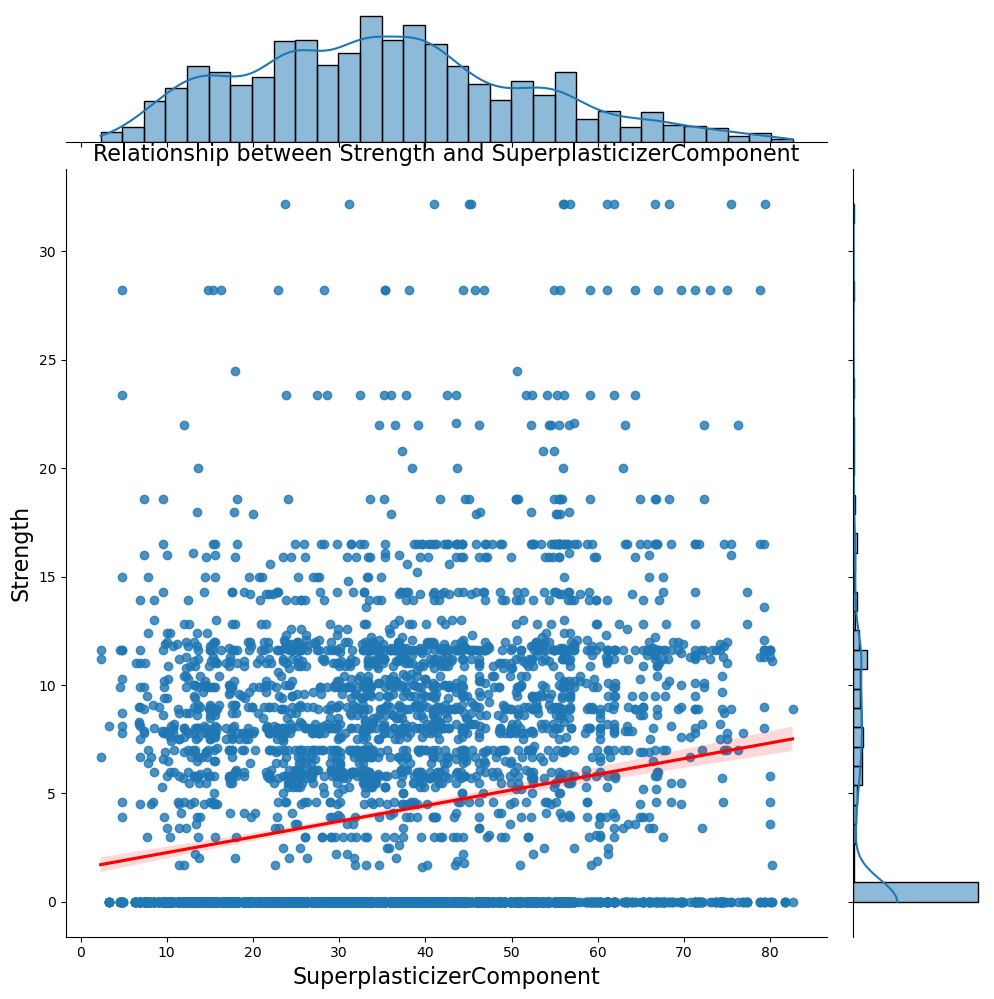

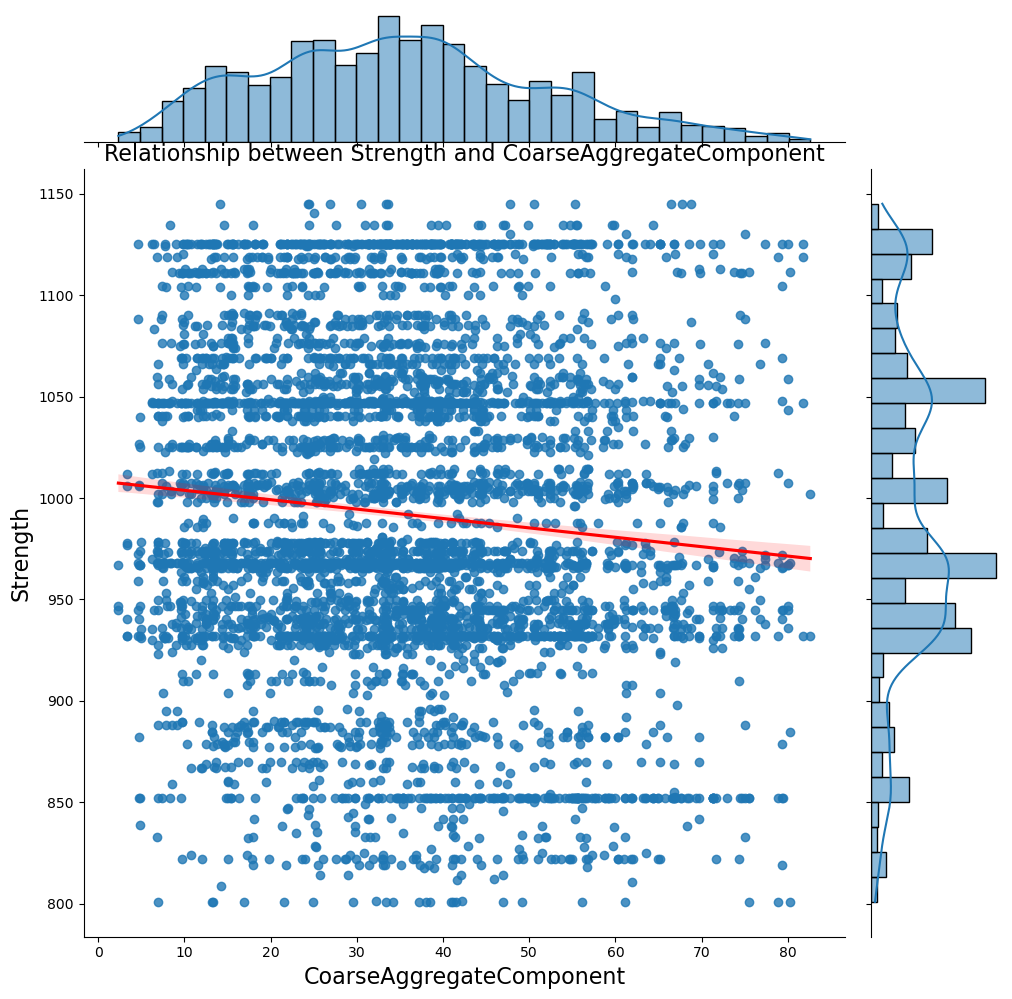

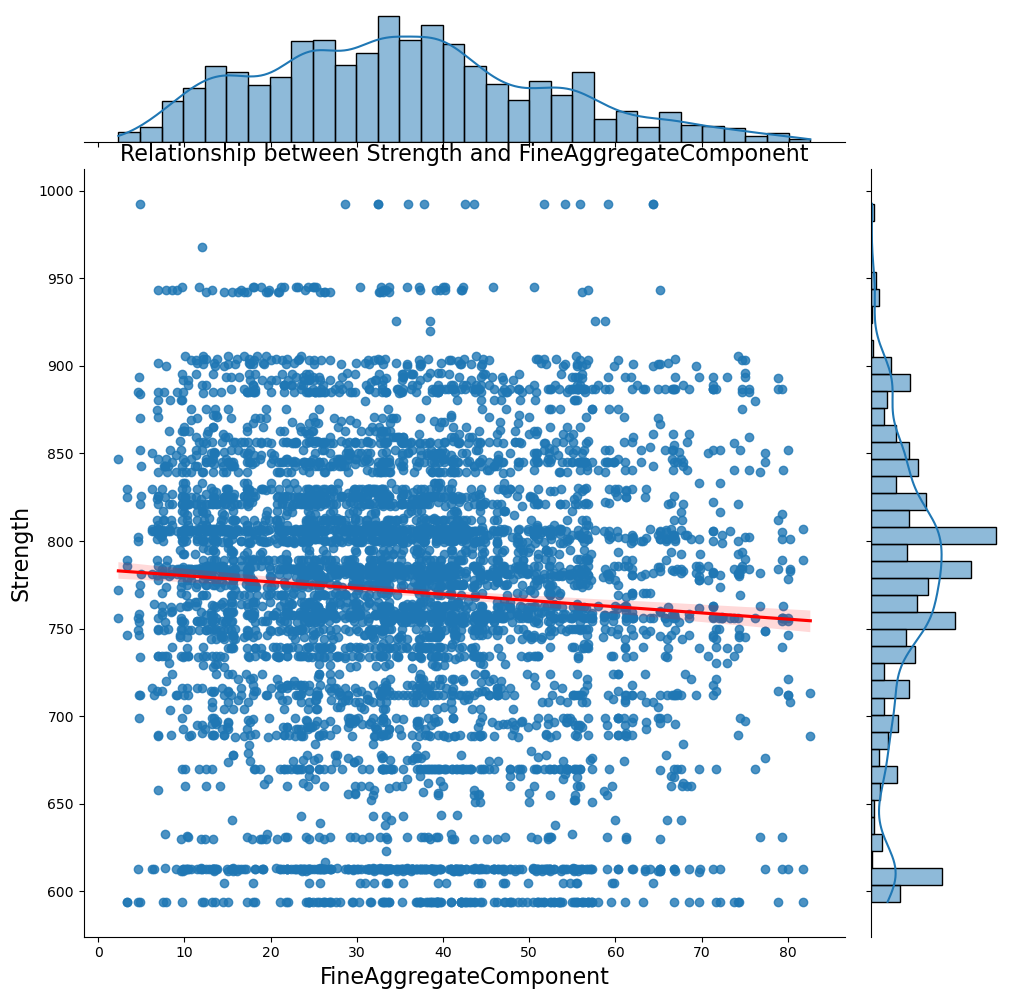

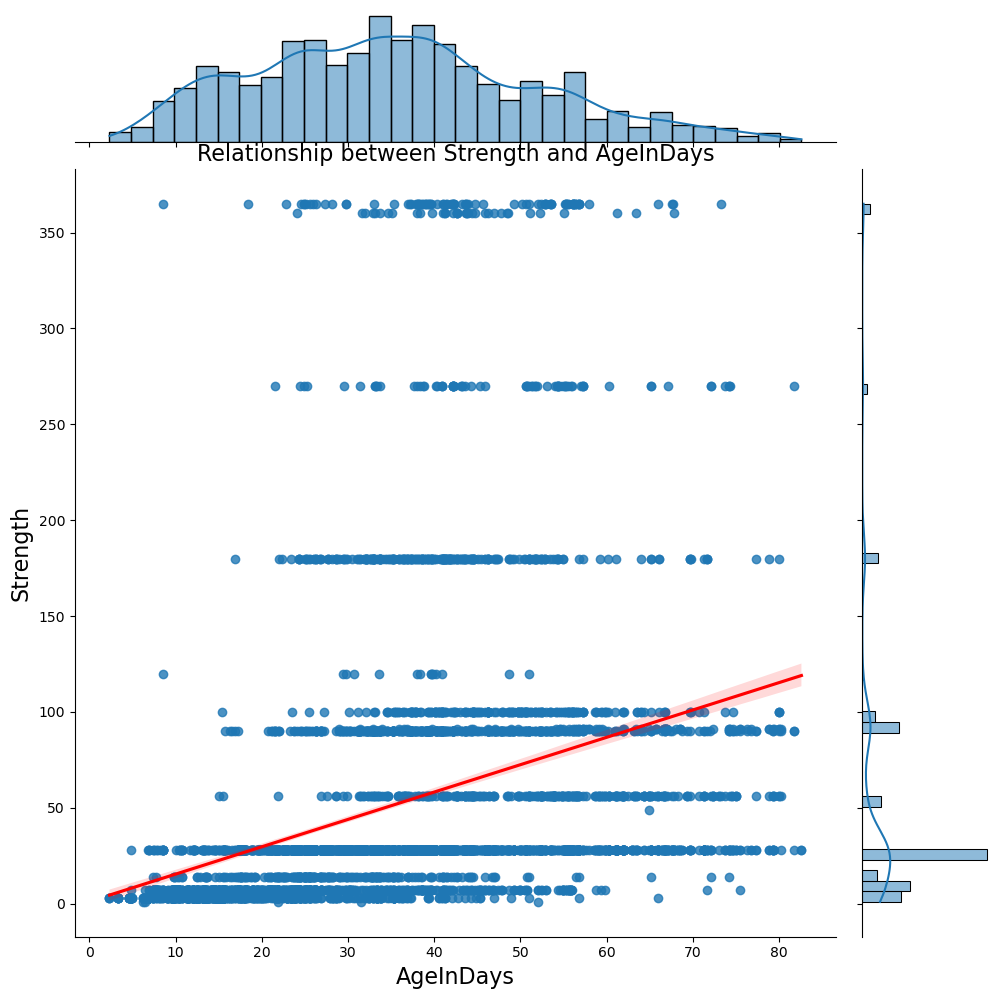

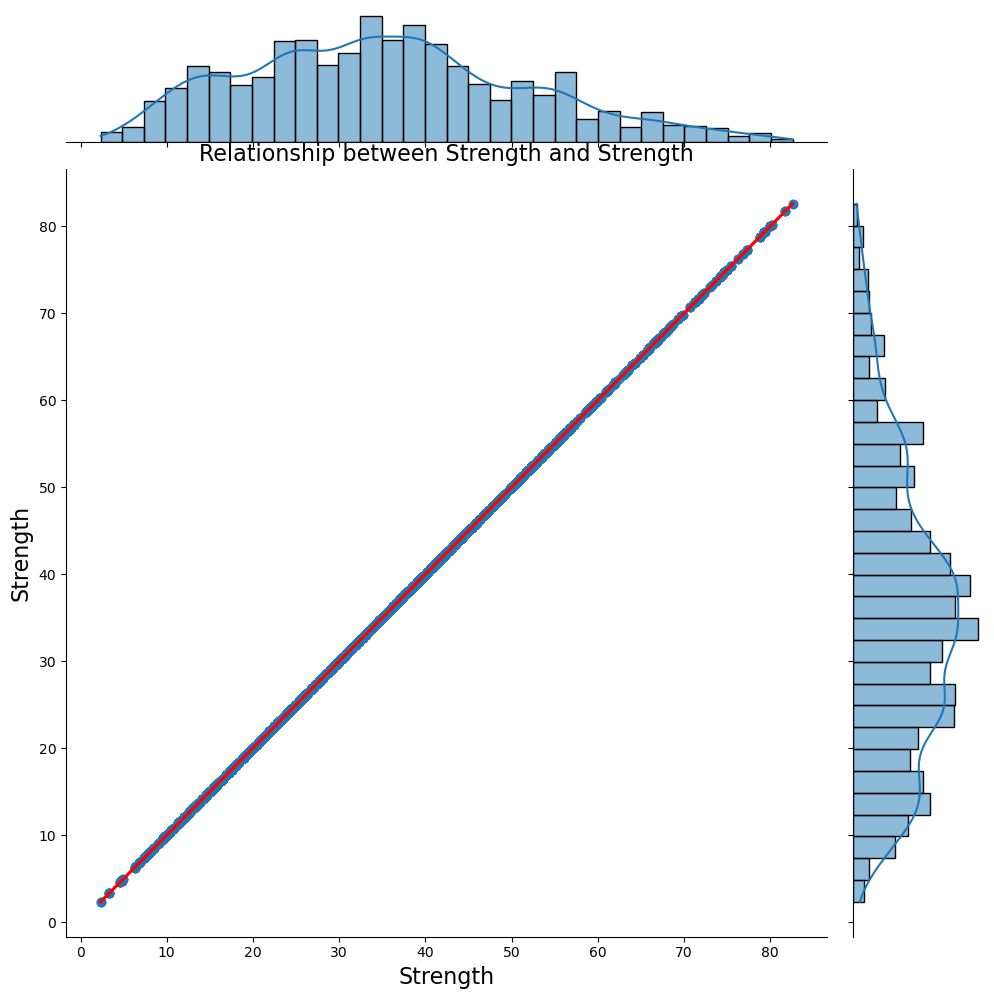

In [13]:
#showing the relation between the target column (Strength) and other columns

for column in train_df.columns:
    
    
    sns.jointplot(data=train_df, x='Strength' , y=column, height=10,
                  kind='reg',line_kws={"color": "red"})
    
    plt.title('Relationship between Strength and ' + column,size=16)
    plt.xlabel(column,size=16)
    plt.ylabel('Strength',size=16)
    plt.show()

In [14]:
# correlation using pearson method
train_df.corr(method='pearson')['Strength'].sort_values(ascending=False)

Strength                     1.000000
AgeInDays                    0.334204
SuperplasticizerComponent    0.208249
CementComponent              0.158000
BlastFurnaceSlag             0.057506
FlyAshComponent              0.031606
FineAggregateComponent      -0.073900
CoarseAggregateComponent    -0.098410
WaterComponent              -0.113678
Name: Strength, dtype: float64

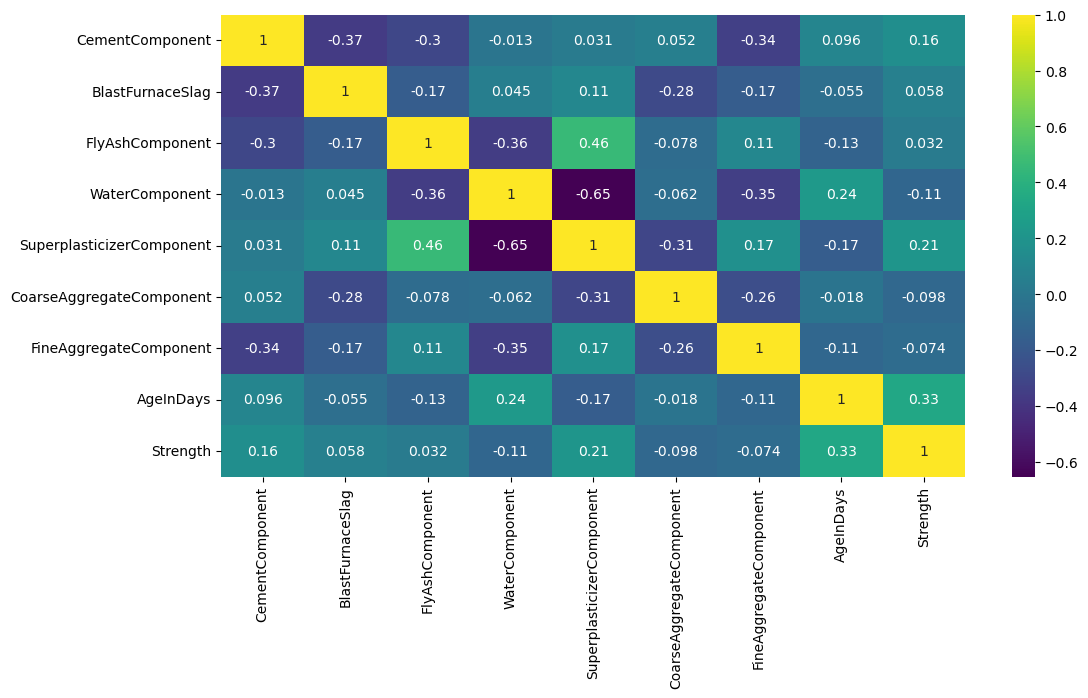

In [15]:
#showing the correlation as a heatmap 
plt.figure(figsize=(12,6))
sns.heatmap(train_df.corr(method='pearson'), annot=True, cmap='viridis')
plt.show()

# Feature Engineering

ideas for new features


In [16]:
def add_features(df):
    
    df['Coarse_Fine'] = df['CoarseAggregateComponent'] / df['FineAggregateComponent']
    df['Aggregate'] = df['CoarseAggregateComponent'] + df['FineAggregateComponent']
    df['Slag_Cement'] = df['BlastFurnaceSlag'] / df['CementComponent']
    df['Ash_Cement'] = df['FlyAshComponent'] / df['CementComponent']
    df['Plastic_Cement'] = df['SuperplasticizerComponent'] / df['CementComponent']
    df['Age_Water'] = df['AgeInDays'] / df['WaterComponent']
    
    
    
    total_composite = (df.WaterComponent + df.CementComponent + df.BlastFurnaceSlag 
                       + df.FlyAshComponent + df.SuperplasticizerComponent 
                       + df.CoarseAggregateComponent + df.FineAggregateComponent)

    df['total_comp'] = total_composite
    df['water_ratio'] = df.WaterComponent / total_composite
    df['cement_ratio'] = df.CementComponent/total_composite
    df['BFS_ratio'] = df.BlastFurnaceSlag/total_composite
    df['FAS_ratio'] = df.FlyAshComponent/total_composite
    df['SP_ratio'] = df.SuperplasticizerComponent/total_composite
    df['CA_ratio'] = df.CoarseAggregateComponent/total_composite
    df['FAG_ratio'] = df.FineAggregateComponent/total_composite
    
    components = [ "WaterComponent", "BlastFurnaceSlag", "FlyAshComponent","CementComponent",
               "SuperplasticizerComponent", "CoarseAggregateComponent", "FineAggregateComponent"]
    df["Components"] = df[components].gt(0).sum(axis=1)
    
    return df

In [17]:
X_train = add_features(X_train)
X_test = add_features(X_test)

# Data Preprocessing

In [18]:
#showing the most skewed columns to fix them 
X_train.skew().sort_values(ascending=False)

AgeInDays                    2.746870
Age_Water                    2.629046
Ash_Cement                   1.927830
Slag_Cement                  1.654174
Plastic_Cement               1.464793
SuperplasticizerComponent    1.411689
SP_ratio                     1.347571
FAS_ratio                    1.316019
FlyAshComponent              1.304692
BlastFurnaceSlag             1.121204
BFS_ratio                    1.112072
Coarse_Fine                  0.834327
Components                   0.386298
CementComponent              0.341278
cement_ratio                 0.248604
water_ratio                  0.064508
CoarseAggregateComponent    -0.081453
total_comp                  -0.203977
WaterComponent              -0.215282
FAG_ratio                   -0.438122
CA_ratio                    -0.440616
FineAggregateComponent      -0.447378
Aggregate                   -0.642461
dtype: float64

> -  ` There is Multiple skewed columns we will fix them using log transformation `
> -  ` we will normalize other data too ` 

In [19]:
#applying power transformer to the data
pt = PowerTransformer(standardize=True)

X_train = pd.DataFrame(columns=X_train.columns, data=pt.fit_transform(X_train))
X_test = pd.DataFrame(columns=X_test.columns, data=pt.transform(X_test))

In [20]:
#check for the skewness again
X_train.skew().sort_values(ascending=False)

Ash_Cement                   1.065543
FAS_ratio                    1.048784
FlyAshComponent              1.016450
Slag_Cement                  0.682952
BFS_ratio                    0.624321
Plastic_Cement               0.518731
SP_ratio                     0.501938
BlastFurnaceSlag             0.387455
SuperplasticizerComponent    0.378342
Age_Water                    0.356632
Components                   0.090635
WaterComponent               0.040811
total_comp                   0.037282
cement_ratio                 0.022186
FAG_ratio                    0.011350
CA_ratio                     0.005524
AgeInDays                    0.003751
water_ratio                 -0.001866
Coarse_Fine                 -0.011365
FineAggregateComponent      -0.014283
CoarseAggregateComponent    -0.020650
CementComponent             -0.041973
Aggregate                   -0.046998
dtype: float64

> ` Most of the columns are fixed `

# Machine Learning Models

## We will use Cross Validation to choose between models


In [21]:
# Create KFold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [22]:
# Helper function to get the RMSE of the model 
def test_model(model,X,y):
    # list to store accuracy in 
    score_folds = []
    
    for train_index, test_index in kfold.split(X,y):
        
        X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_valid_fold)
        
        rmse_fold = mean_squared_error(y_true=y_valid_fold,
                                       y_pred=y_pred_fold,
                                       squared=False)
    
        score_folds.append(rmse_fold)
        
    return score_folds
  

## 1- Simple Linear Regression

In [23]:
lin_model = LinearRegression()
lin_rmse = test_model(lin_model, X_train, y_train)
print('Max RMSE of Linear Model : %.3f ' % (np.max(lin_rmse)))
print('Min RMSE of Linear Model : %.3f ' % (np.min(lin_rmse)))
print('Mean, (STD) RMSE of Linear Model : %.3f, (%.3f)' % (np.mean(lin_rmse), np.std(lin_rmse)))

Max RMSE of Linear Model : 13.123 
Min RMSE of Linear Model : 12.190 
Mean, (STD) RMSE of Linear Model : 12.557, (0.337)


## 2- XGB Regressor

In [24]:
XGB_model = XGBRegressor(n_estimators=800,  learning_rate=0.01,
                         max_depth=3,subsample=0.7, colsample_bytree=0.7,
                        reg_lambda= 9, reg_alpha= 9, min_child_weight= 6)

XGB_rmse = test_model(XGB_model, X_train, y_train)

print('Max RMSE of XGB Model : %.3f ' % (np.max(XGB_rmse)))
print('Min RMSE of XGB Model : %.3f ' % (np.min(XGB_rmse)))
print('Mean, (STD) RMSE of XGB Model : %.3f, (%.3f)' % (np.mean(XGB_rmse), np.std(XGB_rmse)))

Max RMSE of XGB Model : 12.796 
Min RMSE of XGB Model : 11.589 
Mean, (STD) RMSE of XGB Model : 12.076, (0.372)


In [25]:
# y_pred_xgb = XGB_model.predict(X_test)
# y_submission_xgb = pd.DataFrame({'id':test_df.index,'Strength':y_pred_xgb})
# y_submission_xgb.to_csv('submission.csv',index=False)

## XGB Regressor Tuning

In [26]:
#i already did it and found that the best parameters are 
#best_xgb_params :-  'subsample': 0.7, 'reg_lambda': 9, 'reg_alpha': 9,
#                     'n_estimators': 800, 'min_child_weight': 6,
#                    'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7

# xgb_param = {'n_estimators':np.arange(200,3000,300),
#          'max_depth':np.arange(2,11,1),
#          'learning_rate':np.arange(0.01,0.1,0.01),
#          'subsample':[0.6,0.7,0.8,0.9,1],
#          'colsample_bytree':[0.6,0.7,0.8,0.9,1],
#           'min_child_weight':np.arange(1,11,1),
#           'reg_alpha':np.arange(0,11,1),       
#           'reg_lambda':np.arange(0,11,1)
# }

# search_xgb = RandomizedSearchCV(estimator=XGBRegressor(),
#                                 param_distributions=xgb_param,
#                                 cv=kfold,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 n_iter=300,
#                                 scoring='neg_root_mean_squared_error'
#                                  )

# search_xgb.fit(X_train,y_train)

In [27]:
# XGB_best = search_xgb.best_estimator_ 
# print('best_xgb_params -- ', search_xgb.best_params_)

## 3- CatBoost

In [28]:
cat_model =  CatBoostRegressor(iterations=300,
                               learning_rate=0.03,
                               depth=6,
                               loss_function='RMSE',
                               l2_leaf_reg=0.2,
                               verbose=0)

cat_rmse = test_model(cat_model, X_train, y_train)

print('Max RMSE of cat Model : %.3f ' % (np.max(cat_rmse)))
print('Min RMSE of cat Model : %.3f ' % (np.min(cat_rmse)))
print('Mean, (STD) RMSE of cat Model : %.3f, (%.3f)' % (np.mean(cat_rmse), np.std(cat_rmse)))


Max RMSE of cat Model : 12.744 
Min RMSE of cat Model : 11.633 
Mean, (STD) RMSE of cat Model : 12.075, (0.367)


In [29]:
# y_pred_cat = cat_model.predict(X_test)
# y_submission_cat = pd.DataFrame({'id':test_df.index,'Strength':y_pred_cat})
# y_submission_cat.to_csv('submission.csv',index=False)

## CatBoost Tuning

In [30]:
#i already did it and found that the best parameters are 
#best_cat_params --  'learning_rate': 0.03, 'l2_leaf_reg': 0.2, 'iterations': 300, 'depth': 6

# cat_param = {'iterations': np.arange(100,3000,200),
#              'learning_rate': [0.03,0.05,0.08,0.1],
#              'depth': np.arange(2,11,1),
#              'l2_leaf_reg': [0.2, 0.5, 1, 3]}

# search_cat = RandomizedSearchCV(estimator=cat_model,
#                          param_distributions=cat_param,
#                          cv=kfold,
#                          verbose=0,
#                          n_iter=100,
#                          n_jobs=-1)
                                  

# search_cat.fit(X_train,y_train)

In [31]:
# cat_best = search_cat.best_estimator_ 
# print('best_cat_params -- ', search_cat.best_params_)

## Creating an ensemble of models

In [32]:
ens_model = VotingRegressor(estimators=[('xgb', XGB_model), ('cat', cat_model)], weights=[1,1])
                         
ens_model_rmse = test_model(ens_model, X_train, y_train)

print('Max RMSE of ensemble Model : %.3f ' % (np.max(ens_model_rmse)))
print('Min RMSE of ensemble Model : %.3f ' % (np.min(ens_model_rmse)))
print('Mean, (STD) RMSE of ensemble Model : %.3f, (%.3f)' % (np.mean(ens_model_rmse), np.std(ens_model_rmse)))

Max RMSE of ensemble Model : 12.759 
Min RMSE of ensemble Model : 11.598 
Mean, (STD) RMSE of ensemble Model : 12.064, (0.369)


## Tuning the weights of the ensemble model to get the best

In [33]:
# creating a list of all possiple combination of weights from 1 to 9
weights_list = list(itertools.permutations(np.arange(1,10,1), 2))

In [34]:
ens_param = {'weights':weights_list}

search_ens = GridSearchCV(estimator=ens_model, param_grid=ens_param, cv=kfold)

search_ens.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=VotingRegressor(estimators=[('xgb',
                                                    XGBRegressor(base_score=0.5,
                                                                 booster='gbtree',
                                                                 callbacks=None,
                                                                 colsample_bylevel=1,
                                                                 colsample_bynode=1,
                                                                 colsample_bytree=0.7,
                                                                 early_stopping_rounds=None,
                                                                 enable_categorical=False,
                                                                 eval_metric=None,
                                                                 gamma=0,
                              

In [35]:
ens_best = search_ens.best_estimator_ 
print('best_cat_params -- ', search_ens.best_params_)

best_cat_params --  {'weights': (8, 9)}


In [36]:
best_ens_model_rmse = test_model(ens_best, X_train, y_train)

print('Max RMSE of best ensemble Model : %.3f ' % (np.max(best_ens_model_rmse)))
print('Min RMSE of best ensemble Model : %.3f ' % (np.min(best_ens_model_rmse)))
print('Mean, (STD) RMSE of best ensemble Model : %.3f, (%.3f)' % (np.mean(best_ens_model_rmse), np.std(best_ens_model_rmse)))

Max RMSE of best ensemble Model : 12.758 
Min RMSE of best ensemble Model : 11.599 
Mean, (STD) RMSE of best ensemble Model : 12.064, (0.369)


## Predicting the test set using the best ensemble model

In [37]:
y_pred = ens_best.predict(X_test)
y_submission = pd.DataFrame({'id':test_df.index,'Strength':y_pred})
y_submission.to_csv('submission.csv',index=False)

## Comparing the distributions of the test target column and the training target column

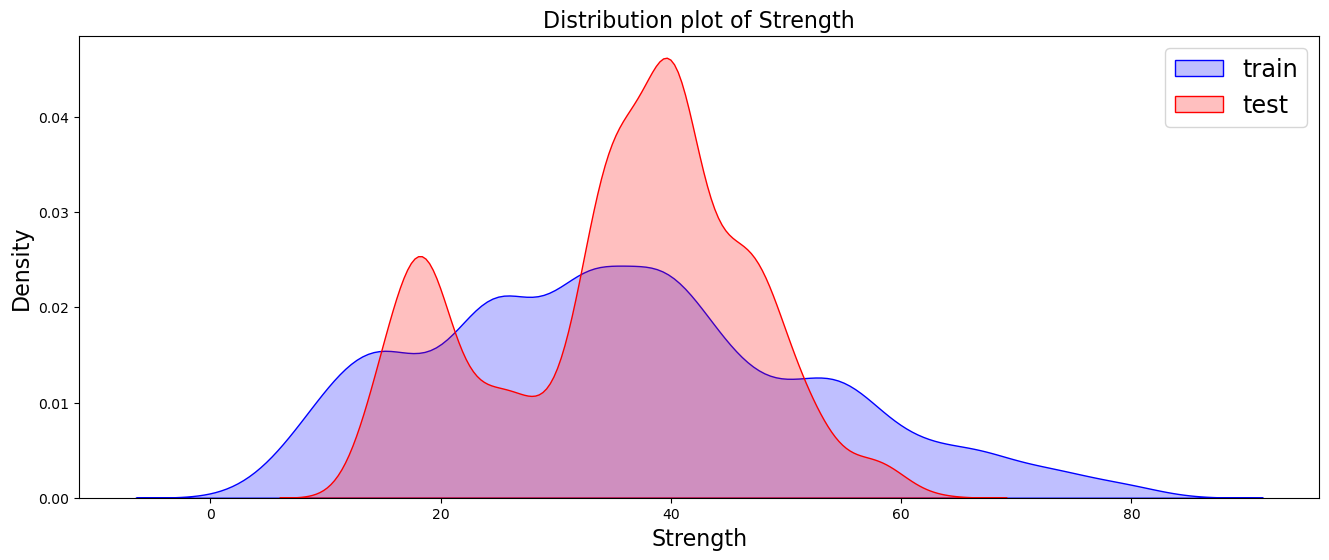

In [38]:
    plt.figure(figsize=(16,6))
    sns.kdeplot(data=train_df, x='Strength', fill=True, color="blue", label='train')
    sns.kdeplot(data=y_submission, x='Strength', fill=True, color="red", label='test')
    plt.legend(fontsize='xx-large')
    plt.title('Distribution plot of '+column,size=16)
    plt.xlabel(column,size=16)
    plt.ylabel('Density',size=16)
    plt.show()